In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeparableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'

'''

In [2]:
test_parameter = [101e-4, 202e-5, 505e-6]
test_amps = [7, 3, 30]
test_x = np.arange(12820, 15120, 4.6)
times = np.asarray(np.arange(0, 500, 1.5))
simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2",202e-4)
simparams.add("p3",505e-5)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1     0.101     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None


In [3]:
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 0.00202 Label: None
Index: 3 Initial Value: 0.000505 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: None


K-Matrices
----------

Label: k1
Matrix:
[[2 0 0]
 [0 3 0]
 [0 0 1]]


IRFs
----




In [4]:
fitmodel = KineticSeparableModel(model)

In [5]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 
                                           'noise':True, 'noise_std_dev':1,
                                           'dataset1_x': test_x,
                                           'amplitudes':[7, 30, 3],
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })

(334, 501)


<IPython.core.display.Javascript object>


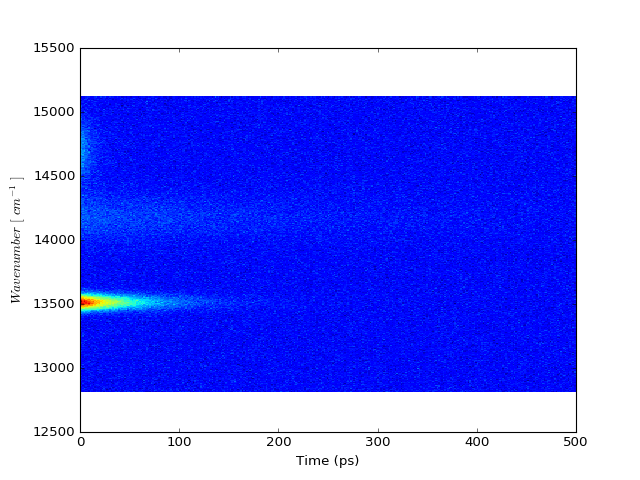

In [6]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, data.T)
plt.show()

In [7]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"dataset1": data, 'verbose':1}
                     )
result.best_fit_parameter.pretty_print()
reconstructed_data = result.eval(*times, **{"dataset1": data})

`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 8.8558e+04, final cost 8.2575e+04, first-order optimality 9.07e-01.
Name     Value      Min      Max   Stderr     Vary     Expr
p1    0.1002     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3  0.005191     -inf      inf     None     True     None


(334, 501)


<IPython.core.display.Javascript object>


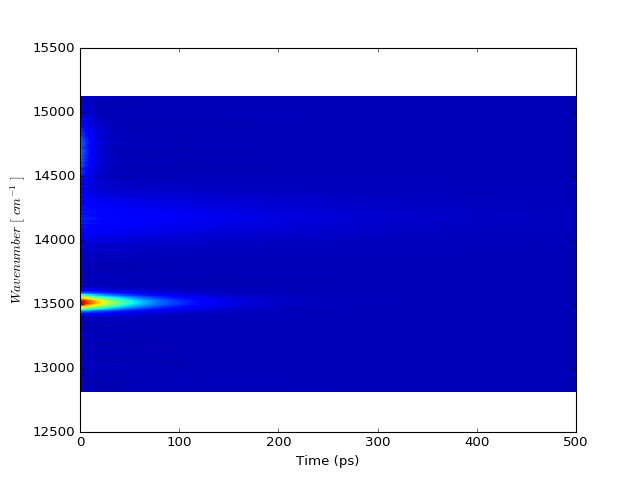

In [8]:
# Plot full trace
print(reconstructed_data.shape)
fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, reconstructed_data.T)
plt.show()

(3, 501)


<IPython.core.display.Javascript object>


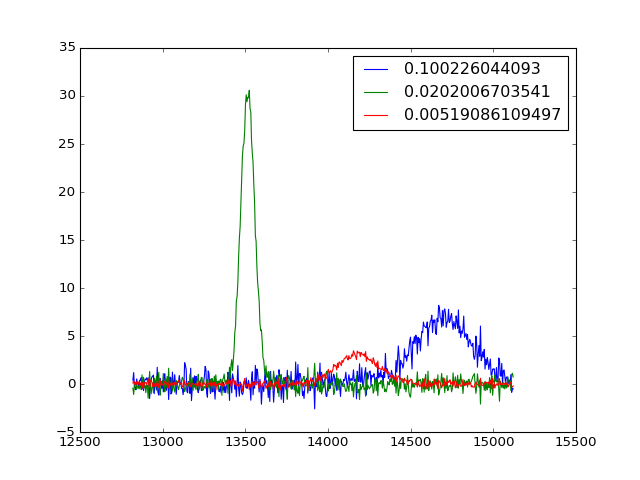

In [9]:
# DAS
DAS = result.coefficients(*times, **{'dataset':'dataset1', "dataset1": data})
print(DAS.shape)
fig = plt.figure()
d1, = plt.plot(test_x, DAS[0, :], label=result.best_fit_parameter['p1'].value)
d2, = plt.plot(test_x, DAS[1, :], label=result.best_fit_parameter['p2'].value)
d3, = plt.plot(test_x, DAS[2, :], label=result.best_fit_parameter['p3'].value)
plt.legend(handles=[d1, d2, d3])

em
(501, 3)
[1, 2, 0]
(501,)
(501, 3)


<IPython.core.display.Javascript object>


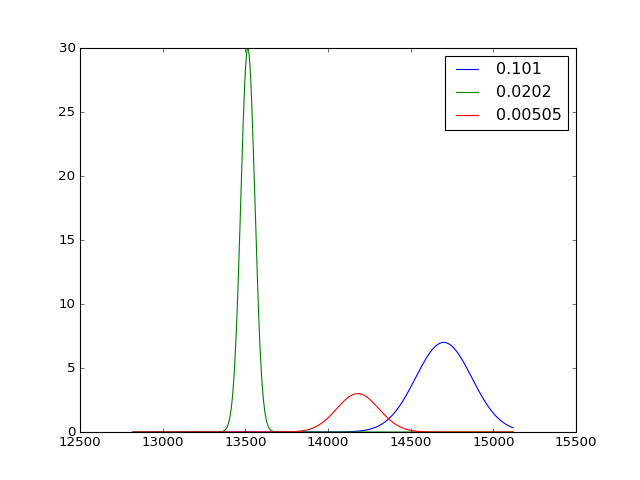

In [10]:
# DAS
DAS = fitmodel.coefficients(**{'dataset':'dataset1','dataset1_x': test_x,
                                           'amplitudes':[7, 30, 3],
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
print(DAS[ :,0].shape)
print(DAS.shape)
fig = plt.figure()
d1, = plt.plot(test_x, DAS[:, 0], label=simparams['p1'].value)
d2, = plt.plot(test_x, DAS[:, 1], label=simparams['p2'].value)
d3, = plt.plot(test_x, DAS[:, 2], label=simparams['p3'].value)
plt.legend(handles=[d1, d2, d3])